In [22]:
import sys
import os
sys.path.insert(0, os.path.expanduser('~/prod_covid19_spread'))
import pandas
import plotly.express as px
import sqlite3
from forecast_db import DB
import yaml
from datetime import timedelta
from IPython.display import SVG, display
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
conn = sqlite3.connect(':memory:')
with sqlite3.connect(DB) as conn_:
    conn_.backup(conn)

In [24]:
loc_map = {
    'new-jersey': {'loc1': 'United States', 'loc2': 'New Jersey'},
    'nystate': {'loc1': 'United States', 'loc2': 'New York'},
    'at': {'loc1': 'Austria'}
}

In [25]:
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_11_09_05/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_22_11_08/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_25_09_00/forecasts/forecast_best_rmse.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_25_08_50/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_07_05_08_32_07/forecasts/forecast_best_mae.csv'

forecast_pth = os.environ.get('FORECAST_PTH', forecast_pth)

cfg = yaml.safe_load(open(os.path.dirname(forecast_pth) + '/../cfg.yml'))
df = pandas.read_csv(forecast_pth, index_col='date', parse_dates=['date'])
var_name = f'loc{len(loc_map[cfg["region"]]) + 1}'
df = df.reset_index().melt(id_vars=['date'], value_name='counts', var_name=var_name)
for k, v in loc_map[cfg['region']].items():
    df[k] = v

df['id'] = 'this_forecast'
df['forecast_date'] = (df['date'].min() - timedelta(days=1)).date()
df.to_sql('infections', conn, if_exists='append', index=False)
basedate = (df['date'].min() - timedelta(days=1)).date()

In [26]:
cond = ' AND '.join([f"inf.{k}='{v}'" for k, v in loc_map[cfg['region']].items()])
cond += f' AND inf.loc{len(loc_map[cfg["region"]]) + 1} IS NOT NULL'

In [27]:
dates = ', '.join([f"'{d}'" for d in df['date'].dt.date.unique()])
spatial_join = ', '.join([f'loc{i}' for i in range(1, len(loc_map[cfg["region"]]) + 2)])
q = f"""
SELECT inf.loc1, inf.loc2, inf.loc3, inf.date, inf.id, inf.counts, inf.forecast_date, gt.counts AS gt
FROM infections inf
LEFT JOIN (SELECT * FROM infections WHERE forecast_date IS NULL) gt USING({spatial_join}, date)
WHERE {cond}
    AND inf.date >= '{basedate - timedelta(days=7)}'
    AND inf.forecast_date >= '{basedate - timedelta(days=7)}' 
    AND inf.forecast_date <= '{basedate}' 
"""
forecasts = pandas.read_sql(q, conn, parse_dates=['date', 'forecast_date'])
forecasts['forecast_date'] = forecasts['forecast_date'].dt.date

In [28]:
group_loc = f'loc{len(loc_map[cfg["region"]])}'
grouped = forecasts.groupby([group_loc, 'id', 'forecast_date', 'date']).sum().reset_index()
grouped['color'] = grouped['forecast_date'].apply(str) + '_' + grouped['id']

In [29]:
forecasts[forecasts['id'] == 'cv_ar']

,loc1,loc2,loc3,date,id,counts,forecast_date,gt
112,United States,New York,Albany,2020-06-29,cv_ar,2103.245065,2020-06-28,2099.0
113,United States,New York,Albany,2020-06-30,cv_ar,2109.029040,2020-06-28,2102.0
114,United States,New York,Albany,2020-07-01,cv_ar,2114.350817,2020-06-28,2112.0
115,United States,New York,Albany,2020-07-02,cv_ar,2119.856172,2020-06-28,2125.0
116,United States,New York,Albany,2020-07-03,cv_ar,2125.780034,2020-06-28,2130.0
...,...,...,...,...,...,...,...,...
10404,United States,New York,Yates,2020-07-08,cv_ar,48.940463,2020-07-05,NaN
10405,United States,New York,Yates,2020-07-09,cv_ar,49.208336,2020-07-05,NaN
10406,United States,New York,Yates,2020-07-10,cv_ar,49.505943,2020-07-05,NaN
10407,United States,New York,Yates,2020-07-11,cv_ar,49.779635,2020-07-05,NaN


# Largest Divergence

#### A list of counties with the largest divergence from the previous forecast

In [30]:
last_date = forecasts[forecasts['id'] == f'cv_ar']['forecast_date'].max()
from datetime import date
locs = [f'loc{i}' for i in range(1, len(loc_map[cfg['region']]) + 2)]
suffixes = ('_this_forecast', f'_{last_date}')
df1 = forecasts[forecasts['id'] == 'this_forecast']
df2 = forecasts[(forecasts['id'] == 'cv_ar') & (forecasts['forecast_date'] == date(2020, 6, 24))]
x = df1.merge(df2, on=locs + ['date'], suffixes=suffixes)
x['diff'] = (x['counts_this_forecast'] - x[f'counts_{last_date}']).abs()
x['days_out'] = x['date'].dt.date - x['forecast_date_this_forecast']
cols = locs + ['date', 'days_out', 'counts_this_forecast', f'counts_{last_date}', 'diff']
x.loc[x.groupby(locs)['diff'].idxmax()].sort_values(by='diff', ascending=False)[cols].iloc[:10]

,loc1,loc2,loc3,date,days_out,counts_this_forecast,counts_2020-07-05,diff


# Forecast Trajectories

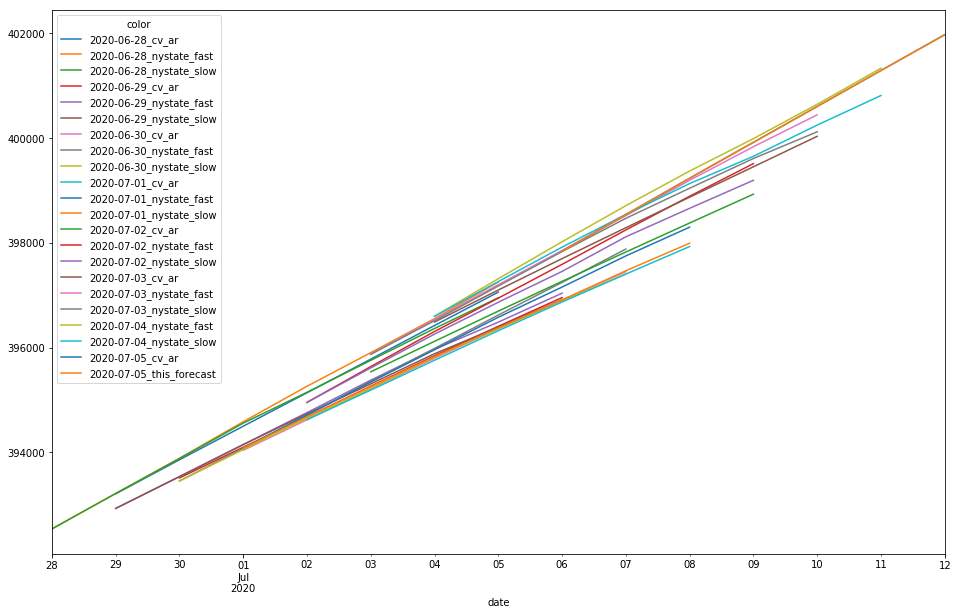

In [31]:
fig = grouped.pivot(index='date', columns='color', values='counts').plot(figsize=(16, 10))

# Mean Absolute Error

In [33]:
with_gt = forecasts[~forecasts['gt'].isnull()].copy()
with_gt['mae'] = (with_gt['gt'] - with_gt['counts']).abs()
with_gt.groupby(['forecast_date', 'id'])['mae'].mean().sort_index().to_frame()

mae
forecast_date id                     
2020-06-28    cv_ar          8.299122
              nystate_fast   9.178571
              nystate_slow   9.605991
2020-06-29    cv_ar          8.246204
              nystate_fast   6.258065
              nystate_slow   6.567204
2020-06-30    cv_ar          9.004118
              nystate_fast   6.311290
              nystate_slow   6.756452
2020-07-01    cv_ar         10.548514
              nystate_fast   6.723790
              nystate_slow   7.195565
2020-07-02    cv_ar          7.261983
              nystate_fast   3.784946
              nystate_slow   4.034946
2020-07-03    cv_ar          2.695738
              nystate_fast   1.205645
              nystate_slow   1.350806
2020-07-04    nystate_fast   0.000000
              nystate_slow   0.000000